# Example of usage Spark OCR for Tables Recognition

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../spark-ocr/target/scala-2.12/" #"../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['SPARK_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
imagePath = "./data/tab_images_hocr_1/*.jpg"

In [2]:
#%%bash
#if python -c 'import google.colab' &> /dev/null; then
#    echo "Run on Google Colab!"
#    echo "Install Open JDK"
#    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
#    java -version
#fi

In [3]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install --upgrade spark-ocr==4.0.0+spark32 --user --extra-index-url https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [4]:
from pyspark import SparkConf
from sparkocr import start

spark = start(jar_path=spark_ocr_jar_path)

spark

Spark version: 3.2.2
Spark NLP version: 4.1.0
Spark NLP for Healthcare version: 4.1.0
Spark OCR version: 4.2.1



## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


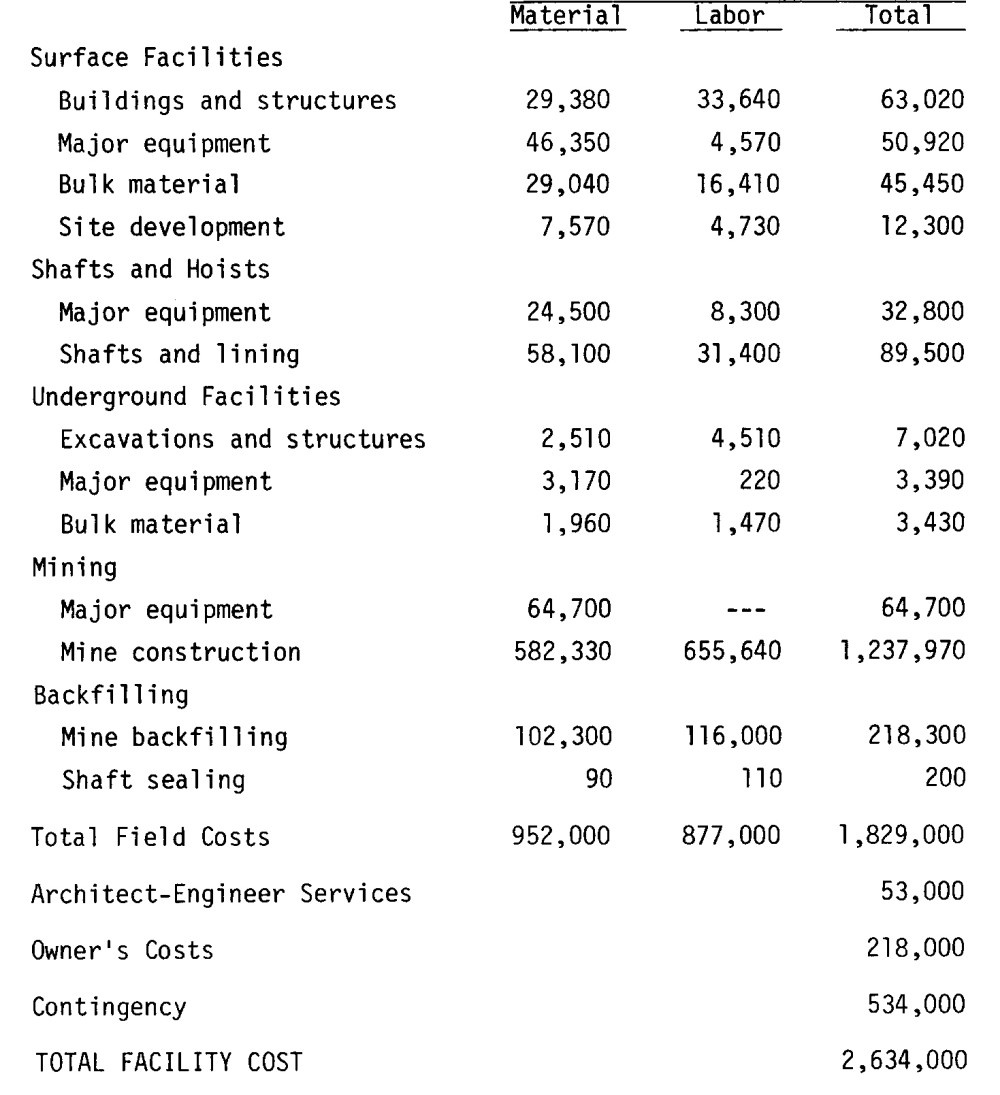

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("table_regions")

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("table_regions")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(ImageType.TYPE_BYTE_GRAY)

#img_to_hocr = ImageToHocr()\
#    .setInputCol("image")\
#    .setOutputCol("hocr")\
#    .setIgnoreResolution(False)\
#    .setOcrParams(["preserve_interword_spaces=0"])

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
        .setInputCol("image") \
        .setOutputCol("text_regions") \
        .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

img_to_hocr = ImageToTextV2().pretrained("ocr_small_printed", "en", "clinical/ocr") \
        .setInputCols(["image", "text_regions"]) \
        .setUsePandasUdf(False) \
        .setOutputFormat(OcrOutputFormat.HOCR) \
        .setOutputCol("hocr") \
        .setGroupImages(False)

hocr_to_table = HocrToTextTable() \
        .setInputCol("hocr") \
        .setRegionCol("table_regions") \
        .setOutputCol("tables")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB


table_image,image,pagenum,table_regions,modificationTime,path,length,text_regions,image_with_regions,hocr,tables,exception,table_index
{file:/home/alexa...,{file:/home/alexa...,0,"{0, 0, 40.0, 0.0,...",2022-12-12 20:17:32,file:/home/alexan...,172124,"[{0, 0, 566.32025...",{file:/home/alexa...,"<?xml version=""1....","{{0, 0, 0.0, 0.0,...",null,0



    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


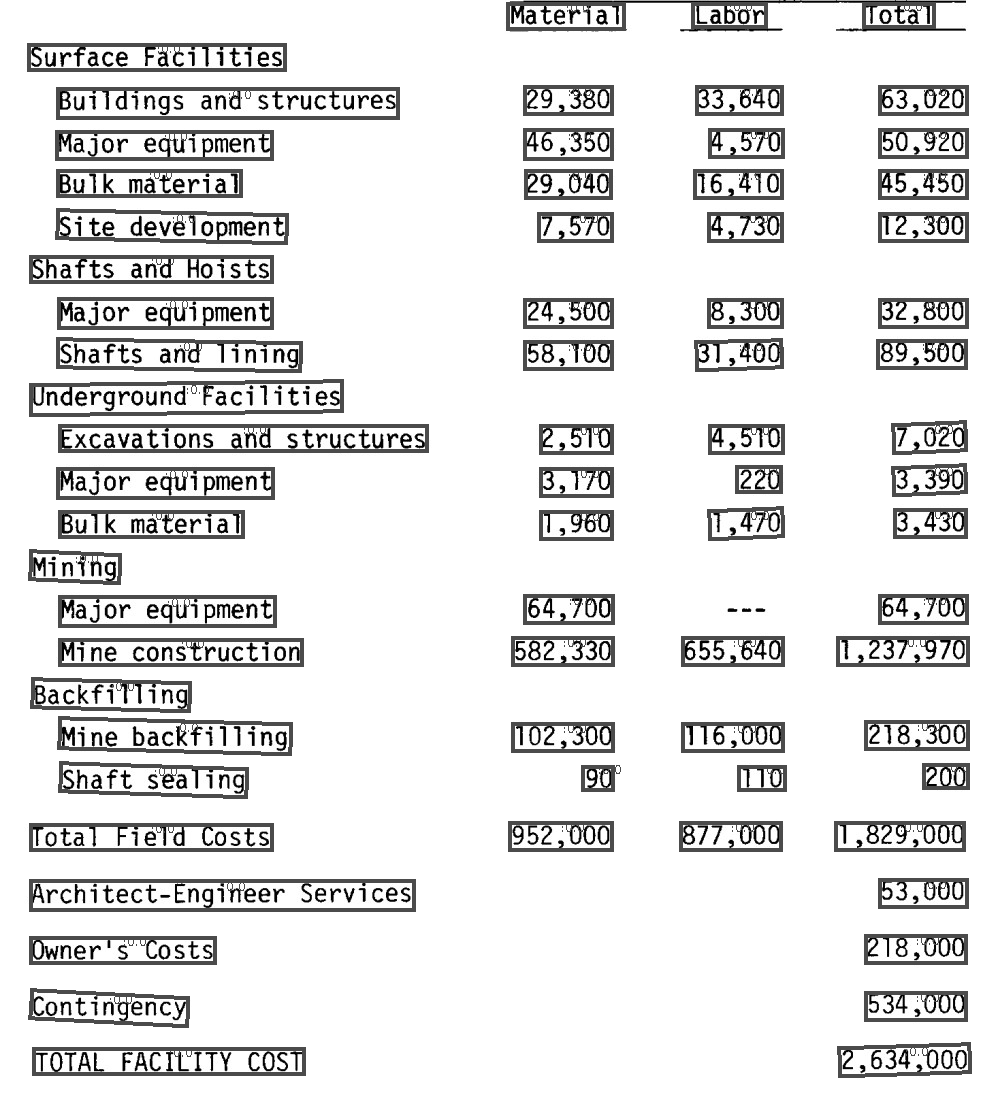

In [9]:
display_images(result, "image_with_regions")

## Run pipeline and show images with tables


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 937 px
    Height: 1093 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


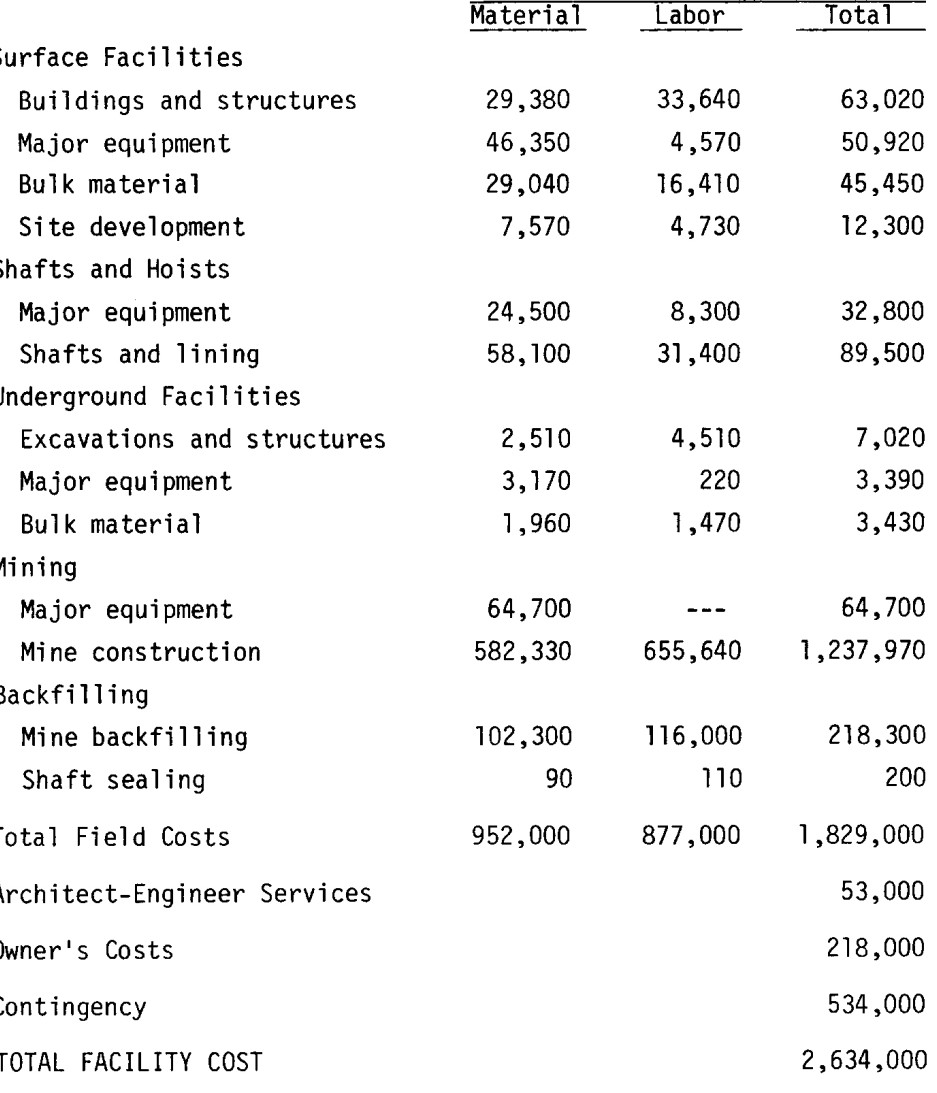

In [10]:
display_images(result, "table_image")

## Display recognized tables

In [8]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: table4_1.jpg
Page:     0
Table:    0
4


,col0,col1,col2,col3
0,,MATERIAL,LABOR,TOTAL
1,SURFACE FACILITIES,None,None,None
2,BUILDINGS AND STRUCTURES,"29,380","33,640","63,020"
3,MAJOR EQUIPMENT,"46,350","4,570","50,920"
4,BULK MATERIAL,"29,040","16,410","45,450"
5,SITE DEVELOPMENT,"7,570","4,730","12,300"
6,SHAFTS AND HOISTS,None,None,None
7,MAJOR EQUIPMENT,"24,500","8,300","32,800"
8,SHAFTS AND LINING,"58,100","31,400","89,500"
9,UNDERGROUND FACILITIES,None,None,None
